In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json

from pathlib import Path
import pandas as pd
import numpy as np
import math
from functional import seq

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import sys

sys.path.append("..")
from sgs_utils.path_conf import (
    speech_data_root_dir,
    speech_data_session_dir,
    loc_data_dir,
    speech_web_app_image_dir
)


In [3]:
df_session = pd.read_parquet(loc_data_dir.joinpath('df_session_uuid.parquet'))

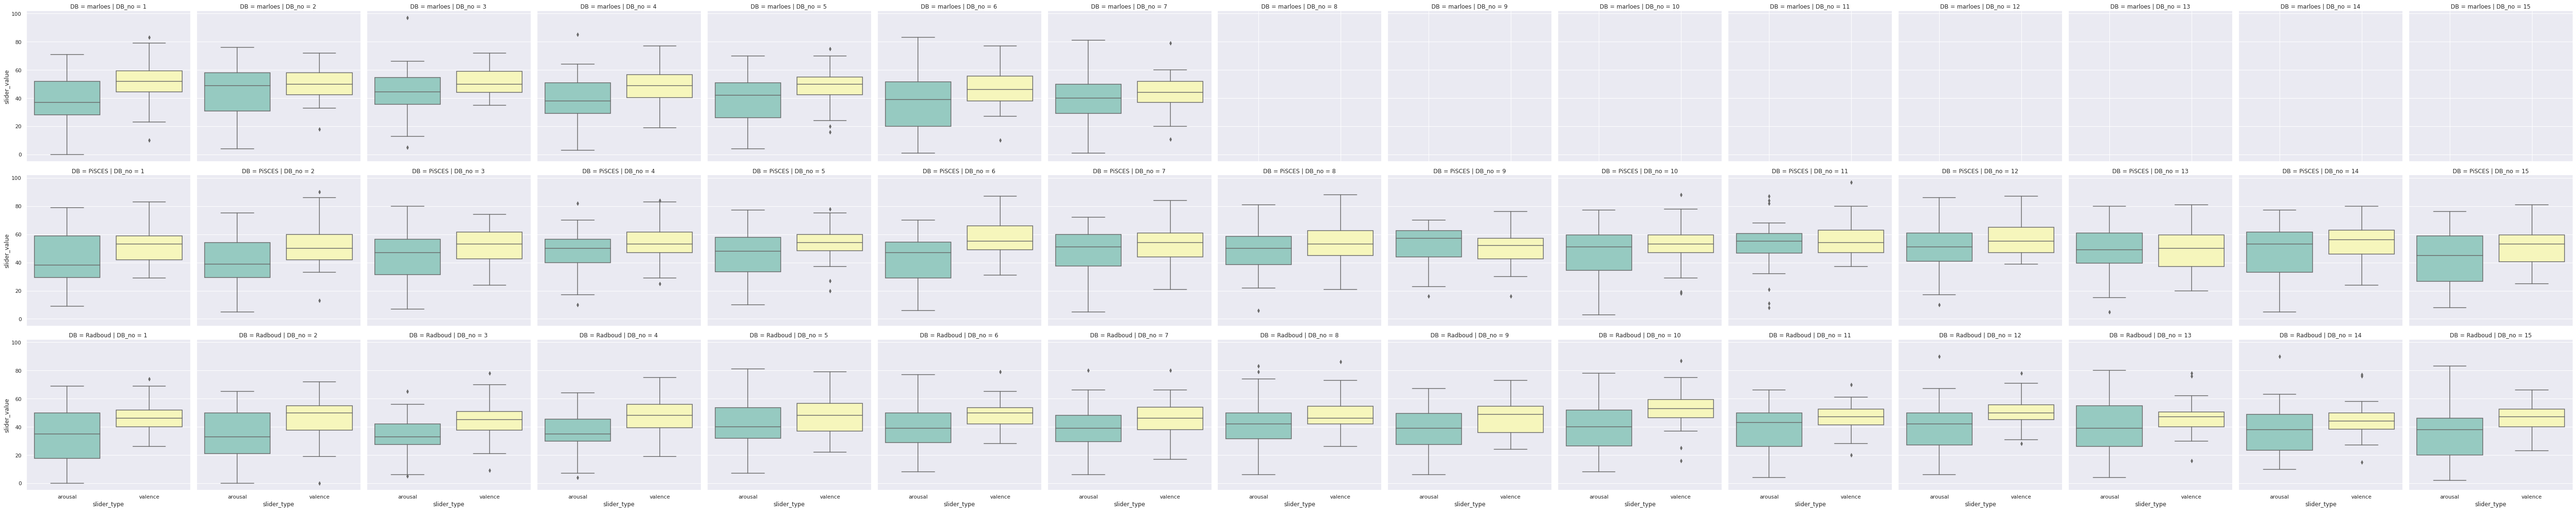

In [4]:
sns.catplot(
    data=df_session[df_session.DB_no < 16].melt(
        id_vars=set(df_session.columns).difference({"arousal", "valence"}),
        value_vars=["arousal", "valence"],
        var_name='slider_type',
        value_name='slider_value'
    ),
    kind='box', 
    x='slider_type',
    y='slider_value',
    row='DB',
    col='DB_no',
    palette='Set3'
)

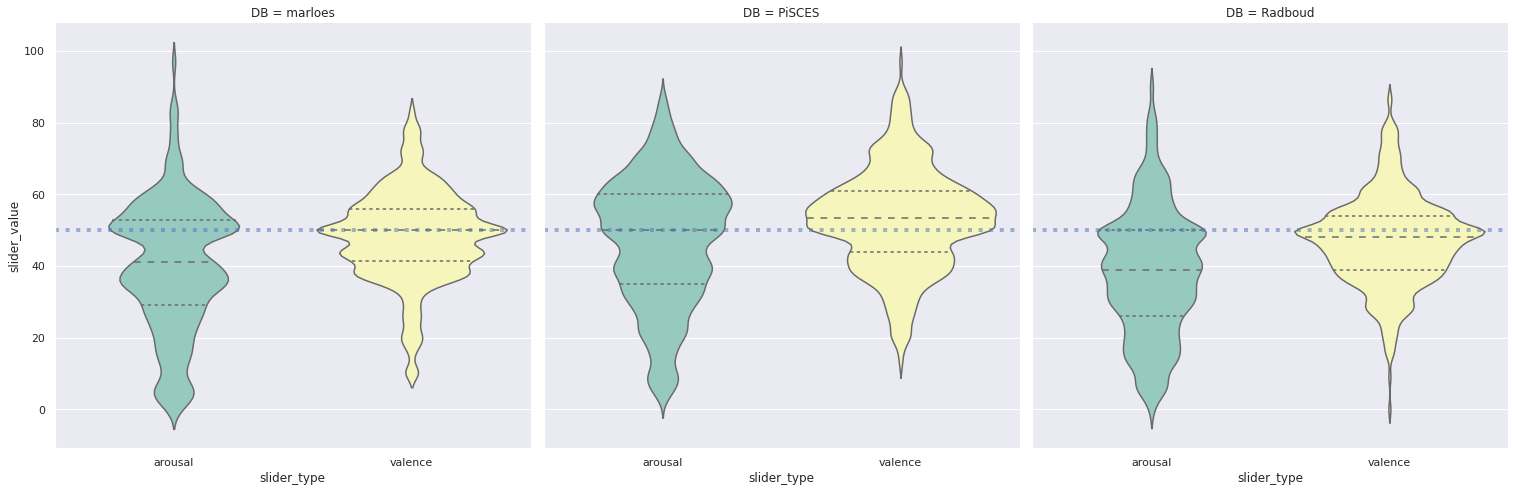

In [5]:
g = sns.catplot(
    data=df_session.melt(
        id_vars=set(df_session.columns).difference({"arousal", "valence"}),
        value_vars=["arousal", "valence"],
        var_name='slider_type',
        value_name='slider_value'
    ),
    sharex=True,
    sharey=True,
    legend=True,
    kind='violin', 
    x='slider_type',
    y='slider_value',
    col='DB',
    palette='Set3',
    bw=.15,
    inner='quartile',
    col_wrap=4,
    height=7
)

for ax in g.axes.flat:
    ax.axhline(50, ls=':', lw=4, alpha=0.5)

## Statistics

In [6]:
from scipy.stats import kstest, mannwhitneyu

In [7]:
df_session.head()

age education     sex                        timestamp  \
0   29      unif  female 2020-11-27 20:02:22.592132+01:00   
1   29      unif  female 2020-11-27 20:02:22.592132+01:00   
2   29      unif  female 2020-11-27 20:02:22.592132+01:00   
3   29      unif  female 2020-11-27 20:02:22.592132+01:00   
4   29      unif  female 2020-11-27 20:02:22.592132+01:00   

                                     ID  Marloes  PiSCES  Radboud device  \
0  0bae55f8-2aab-4c7b-917f-7f0c3e627e5f        7      15       15   None   
1  0bae55f8-2aab-4c7b-917f-7f0c3e627e5f        7      15       15   None   
2  0bae55f8-2aab-4c7b-917f-7f0c3e627e5f        7      15       15   None   
3  0bae55f8-2aab-4c7b-917f-7f0c3e627e5f        7      15       15   None   
4  0bae55f8-2aab-4c7b-917f-7f0c3e627e5f        7      15       15   None   

                                    pic_name  ... wav_size  wav_duration_s  \
0                                    marloes  ...  3252268       33.877333   
1                                Picture 105  ...  4104236       42.752000   
2  Rafd090_24_Caucasian_male_neutral_frontal  ...  3498028       36.437333   
3                                 Picture 82  ...  6848556       71.338667   
4  Rafd090_33_Caucasian_male_neutral_frontal  ...  3186732       33.194667   

        DB arousal  valence                             time DB_no  \
0  marloes    41.0     42.0 2020-11-27 20:11:50.592132+01:00     1   
1   PiSCES    33.0     56.0 2020-11-27 20:13:00.592132+01:00     1   
2  Radboud    44.0     53.0 2020-11-27 20:13:51.592132+01:00     1   
3   PiSCES    43.0     56.0 2020-11-27 20:15:14.592132+01:00     2   
4  Radboud    35.0     61.0 2020-11-27 20:15:59.592132+01:00     2   

   session_no  pic_no                                  uuid  
0           1     NaN  584871ea-39d4-41fe-80f4-1f602bab38f6  
1           2     1.0  206f620d-6c5e-48fd-adff-f44aa4fbb48c  
2           3     2.0  4ac5c802-bb03-4075-8d51-060d39f264fe  
3           4     3.0  cebcc69a-8fa2-4f3e-9ace-cc591df5de2e  
4           5     4.0  ad41210b-3045-4a91-a2d8-9d496439ec2c  

[5 rows x 21 columns]

In [8]:
db_pic_name_var_score_list = []
for db in ["PiSCES", "Radboud"]:
    for pic_name in df_session[df_session.DB == db].pic_name.unique():
        for variable in ["arousal", "valence"]:
            test = mannwhitneyu(
                df_session[(df_session.DB == db) & (df_session.pic_name == pic_name)][
                    variable
                ],
                df_session[(df_session.DB == db) & (df_session.pic_name != pic_name)][
                    variable
                ],
                alternative="two-sided",
                nan_policy="omit",
            )
            db_pic_name_var_score_list.append([db, pic_name, variable, test.pvalue])


In [9]:
db_pic_name_var_score_list = []
for db in ["PiSCES", "Radboud"]:
    for pic_name in df_session[df_session.DB == db].pic_name.unique():
        for variable in ["arousal", "valence"]:
            test = mannwhitneyu(
                df_session[(df_session.DB == db) & (df_session.pic_name == pic_name)][
                    variable
                ],
                df_session[(df_session.DB == db) & (df_session.pic_name != pic_name)][
                    variable
                ],
                alternative="two-sided",
                nan_policy="omit",
            )
            db_pic_name_var_score_list.append([db, pic_name, variable, test.pvalue])


In [10]:
df = pd.DataFrame(
    db_pic_name_var_score_list, columns=["DB", "pic_name", "variable", "p_value"]
).sort_values(by="p_value")
df[df.p_value < 0.05]


DB                                     pic_name variable   p_value
7    PiSCES                                   Picture 65  valence  0.000007
25   PiSCES                                  Picture 132  valence  0.000043
17   PiSCES                                   Picture 56  valence  0.000176
28   PiSCES                                   Picture 98  arousal  0.000446
14   PiSCES                                   Picture 93  arousal  0.003679
35  Radboud    Rafd090_49_Caucasian_male_neutral_frontal  valence  0.005658
48  Radboud  Rafd090_57_Caucasian_female_neutral_frontal  arousal  0.008779
57  Radboud    Rafd090_46_Caucasian_male_neutral_frontal  valence  0.009463
12   PiSCES                                   Picture 59  arousal  0.011833
6    PiSCES                                   Picture 65  arousal  0.012701
26   PiSCES                                   Picture 80  arousal  0.016098
3    PiSCES                                   Picture 82  valence  0.018548
34  Radboud    Rafd090_49_Caucasian_male_neutral_frontal  arousal  0.024844
15   PiSCES                                   Picture 93  valence  0.037309
2    PiSCES                                   Picture 82  arousal  0.044534
59  Radboud  Rafd090_58_Caucasian_female_neutral_frontal  valence  0.047472
55  Radboud  Rafd090_01_Caucasian_female_neutral_frontal  valence  0.048333

### Inter dataset statistics

In [11]:
kstest(df_session.arousal.dropna(), 'norm').pvalue

0.0

In [12]:
kstest(df_session.valence.dropna(), 'norm').pvalue

0.0

In [13]:
kstest(df_session.valence.dropna(), 'norm').pvalue

0.0

In [14]:
for variable, (group_a_mask, name_a), (group_b_mask, name_b) in [
    (
        "arousal",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB == "PiSCES", "PiSCES"),
    ),
    (
        "arousal",
        (df_session.DB == "PiSCES", "PisCes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
    (
        "valence",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB != "marloes", "not-marloes"),
    ),
    (
        "valence",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB == "PiSCES", "PiSCES"),
    ),
    (
        "valence",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
    (
        "valence",
        (df_session.DB == "PiSCES", "PisCes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
]:
    test = mannwhitneyu(
        df_session[group_a_mask][variable],
        df_session[group_b_mask][variable],
        nan_policy="omit",
    )
    print("{:10s}\t{:>10s} - {:15s}\t{:20s}".format(variable, name_a, name_b, str(test.pvalue)))


arousal   	   marloes - PiSCES         	1.373910518003637e-06
arousal   	    PisCes - Radboud        	1.7973379236317823e-14
valence   	   marloes - not-marloes    	0.16265186071246662 
valence   	   marloes - PiSCES         	2.7926216977819575e-05
valence   	   marloes - Radboud        	0.10131985920979983 
valence   	    PisCes - Radboud        	1.0777536663570659e-12


In [15]:
for variable, (group_a_mask, name_a), (group_b_mask, name_b) in [
    (
        "arousal",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB != "marloes", "not-marloes"),
    ),
    (
        "arousal",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB == "PiSCES", "PiSCES"),
    ),
    (
        "arousal",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
    (
        "arousal",
        (df_session.DB == "PiSCES", "PisCes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
    (
        "valence",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB != "marloes", "not-marloes"),
    ),
    (
        "valence",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB == "PiSCES", "PiSCES"),
    ),
    (
        "valence",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
    (
        "valence",
        (df_session.DB == "PiSCES", "PisCes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
]:
    test = mannwhitneyu(
        df_session[group_a_mask][variable],
        df_session[group_b_mask][variable],
        nan_policy="omit",
    )
    print("{:10s}\t{:>10s} - {:15s}\t{:20s}".format(variable, name_a, name_b, str(test.pvalue)))


arousal   	   marloes - not-marloes    	0.07531619183009433 
arousal   	   marloes - PiSCES         	1.373910518003637e-06
arousal   	   marloes - Radboud        	0.11488175706737223 
arousal   	    PisCes - Radboud        	1.7973379236317823e-14
valence   	   marloes - not-marloes    	0.16265186071246662 
valence   	   marloes - PiSCES         	2.7926216977819575e-05
valence   	   marloes - Radboud        	0.10131985920979983 
valence   	    PisCes - Radboud        	1.0777536663570659e-12


In [16]:
# * 2 modellen ; 1 met afh. var. arousal, andere valence. 
# * fixed-effect = dataset 
# * random effect = user_id

# dan nog kijken of andere variabelen een significant contributor zijn
# (Bv. een model met of zonder age als fixed effect)

# generalized linear mixed effects model
# -> kijken naar de fit afh. van de onderliggende distributie die je gebruikt
# -> 

# Marloes: over time

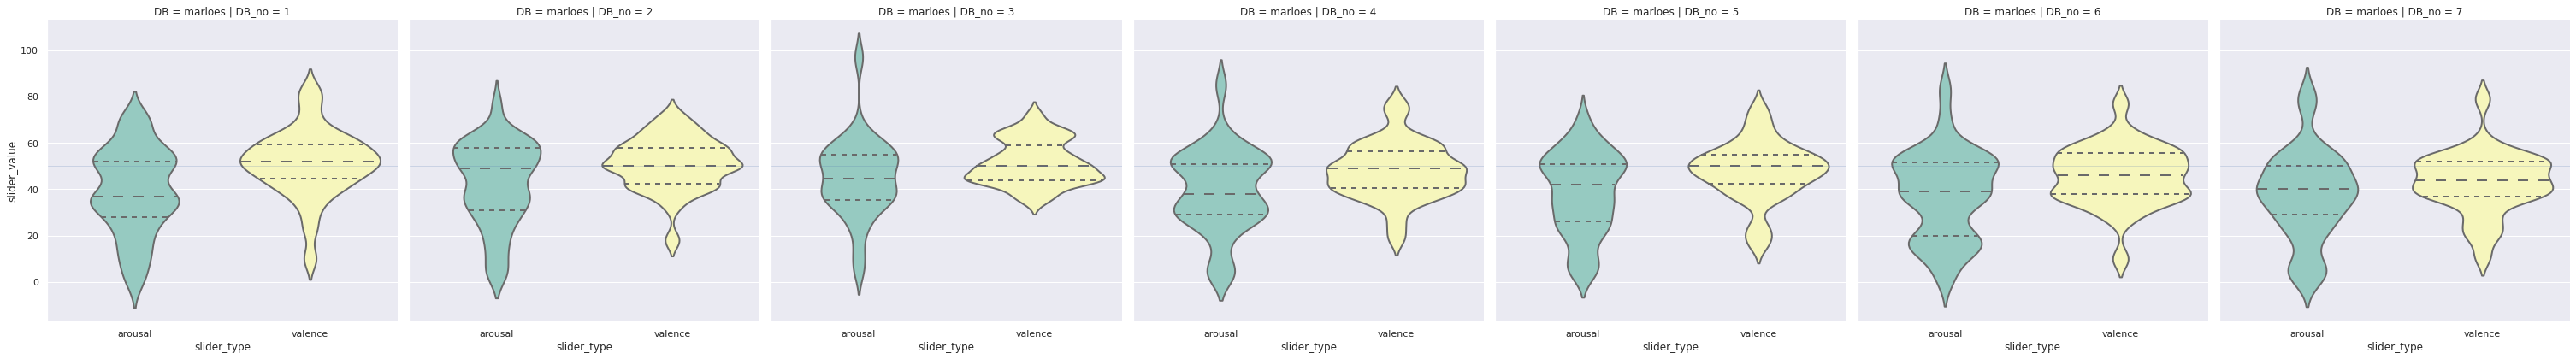

In [17]:
g = sns.catplot(
    data=df_session[df_session.DB == "marloes"].melt(
        id_vars=set(df_session.columns).difference({"arousal", "valence"}),
        value_vars=["arousal", "valence"],
        var_name="slider_type",
        value_name="slider_value",
    ),
    sharex=True,
    sharey=True,
    legend=True,
    kind="violin",
    inner='quartile',
    bw=0.3,
    x="slider_type",
    y="slider_value",
    row="DB",
    col="DB_no",
    height=6,
    palette='Set3',
    linewidth=2,
)

for ax in g.axes.flat:
    ax.axhline(50, lw=1, alpha=0.2)

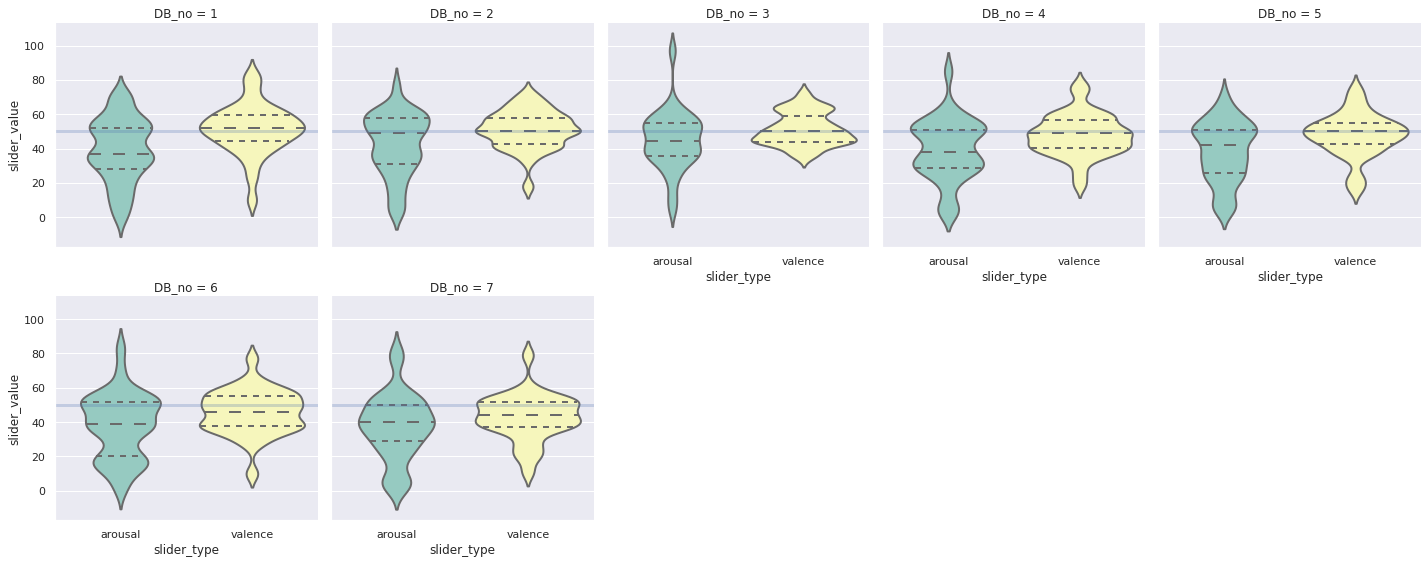

In [18]:
g = sns.catplot(
    data=df_session[df_session.DB == "marloes"].melt(
        id_vars=set(df_session.columns).difference({"arousal", "valence"}),
        value_vars=["arousal", "valence"],
        var_name="slider_type",
        value_name="slider_value",
    ),
    sharex=True,
    sharey=True,
    legend=True,
    kind="violin",
    inner='quartile',
    bw=0.3,
    x="slider_type",
    y="slider_value",
    col_wrap=5,
    col="DB_no",
    height=4,
    palette='Set3',
    linewidth=2,
)

for ax in g.axes.flat:
    ax.axhline(50, lw=3, alpha=0.25)

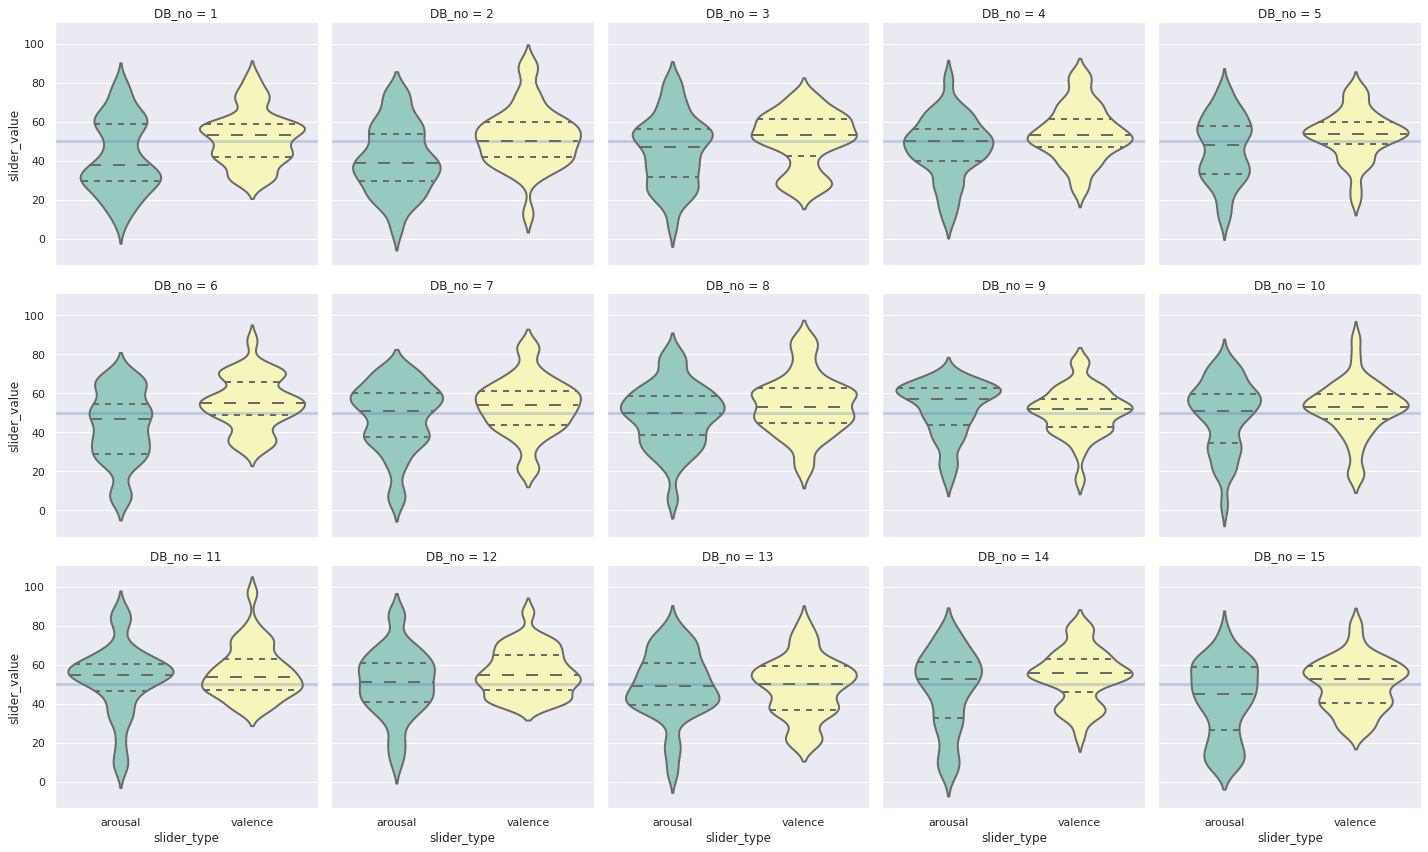

In [19]:
g = sns.catplot(
    data=df_session[(df_session.DB == "PiSCES") & (df_session.DB_no < 16)].melt(
        id_vars=set(df_session.columns).difference({"arousal", "valence"}),
        value_vars=["arousal", "valence"],
        var_name="slider_type",
        value_name="slider_value",
    ),
    sharex=True,
    sharey=True,
    legend=True,
    kind="violin",
    inner="quartile",
    bw=0.3,
    x="slider_type",
    y="slider_value",
    col="DB_no",
    height=4,
    palette="Set3",
    linewidth=2,
    col_wrap=5,
)

for ax in g.axes.flat:
    ax.axhline(50, lw=3, alpha=0.25)


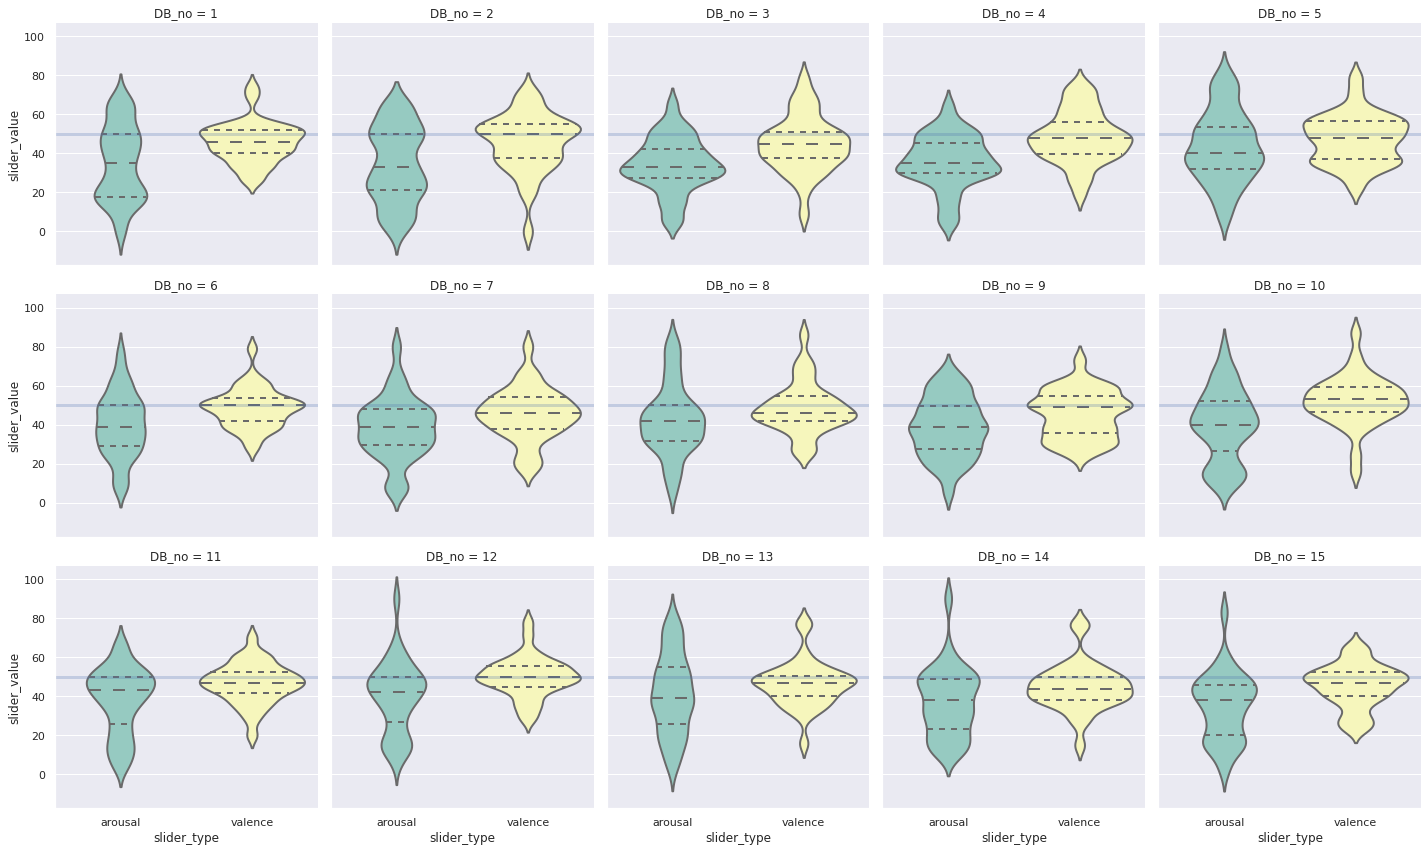

In [20]:
g = sns.catplot(
    data=df_session[(df_session.DB == "Radboud") & (df_session.DB_no < 16)].melt(
        id_vars=set(df_session.columns).difference({"arousal", "valence"}),
        value_vars=["arousal", "valence"],
        var_name="slider_type",
        value_name="slider_value",
    ),
    sharex=True,
    sharey=True,
    legend=True,
    kind="violin",
    inner="quartile",
    bw=0.3,
    x="slider_type",
    y="slider_value",
    col="DB_no",
    height=4,
    palette="Set3",
    linewidth=2,
    col_wrap=5,
)

for ax in g.axes.flat:
    ax.axhline(50, lw=3, alpha=0.25)


# Fig & arousal valence distribution

In [21]:
def set_share_axes(axs, target=None, sharex=False, sharey=False):
    if target is None:
        target = axs.flat[0]
    # Manage share using grouper objects
    for ax in axs.flat:
        if sharex:
            target._shared_axes['x'].join(target, ax)
        if sharey:
            target._shared_axes['y'].join(target, ax)
    # Turn off x tick labels and offset text for all but the bottom row
    if sharex and axs.ndim > 1:
        for ax in axs[:-1,:].flat:
            ax.xaxis.set_tick_params(which='both', labelbottom=False, labeltop=False)
            ax.xaxis.offsetText.set_visible(False)
    # Turn off y tick labels and offset text for all but the left most column
    if sharey and axs.ndim > 1:
        for ax in axs[:,1:].flat:
            ax.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
            ax.yaxis.offsetText.set_visible(False)

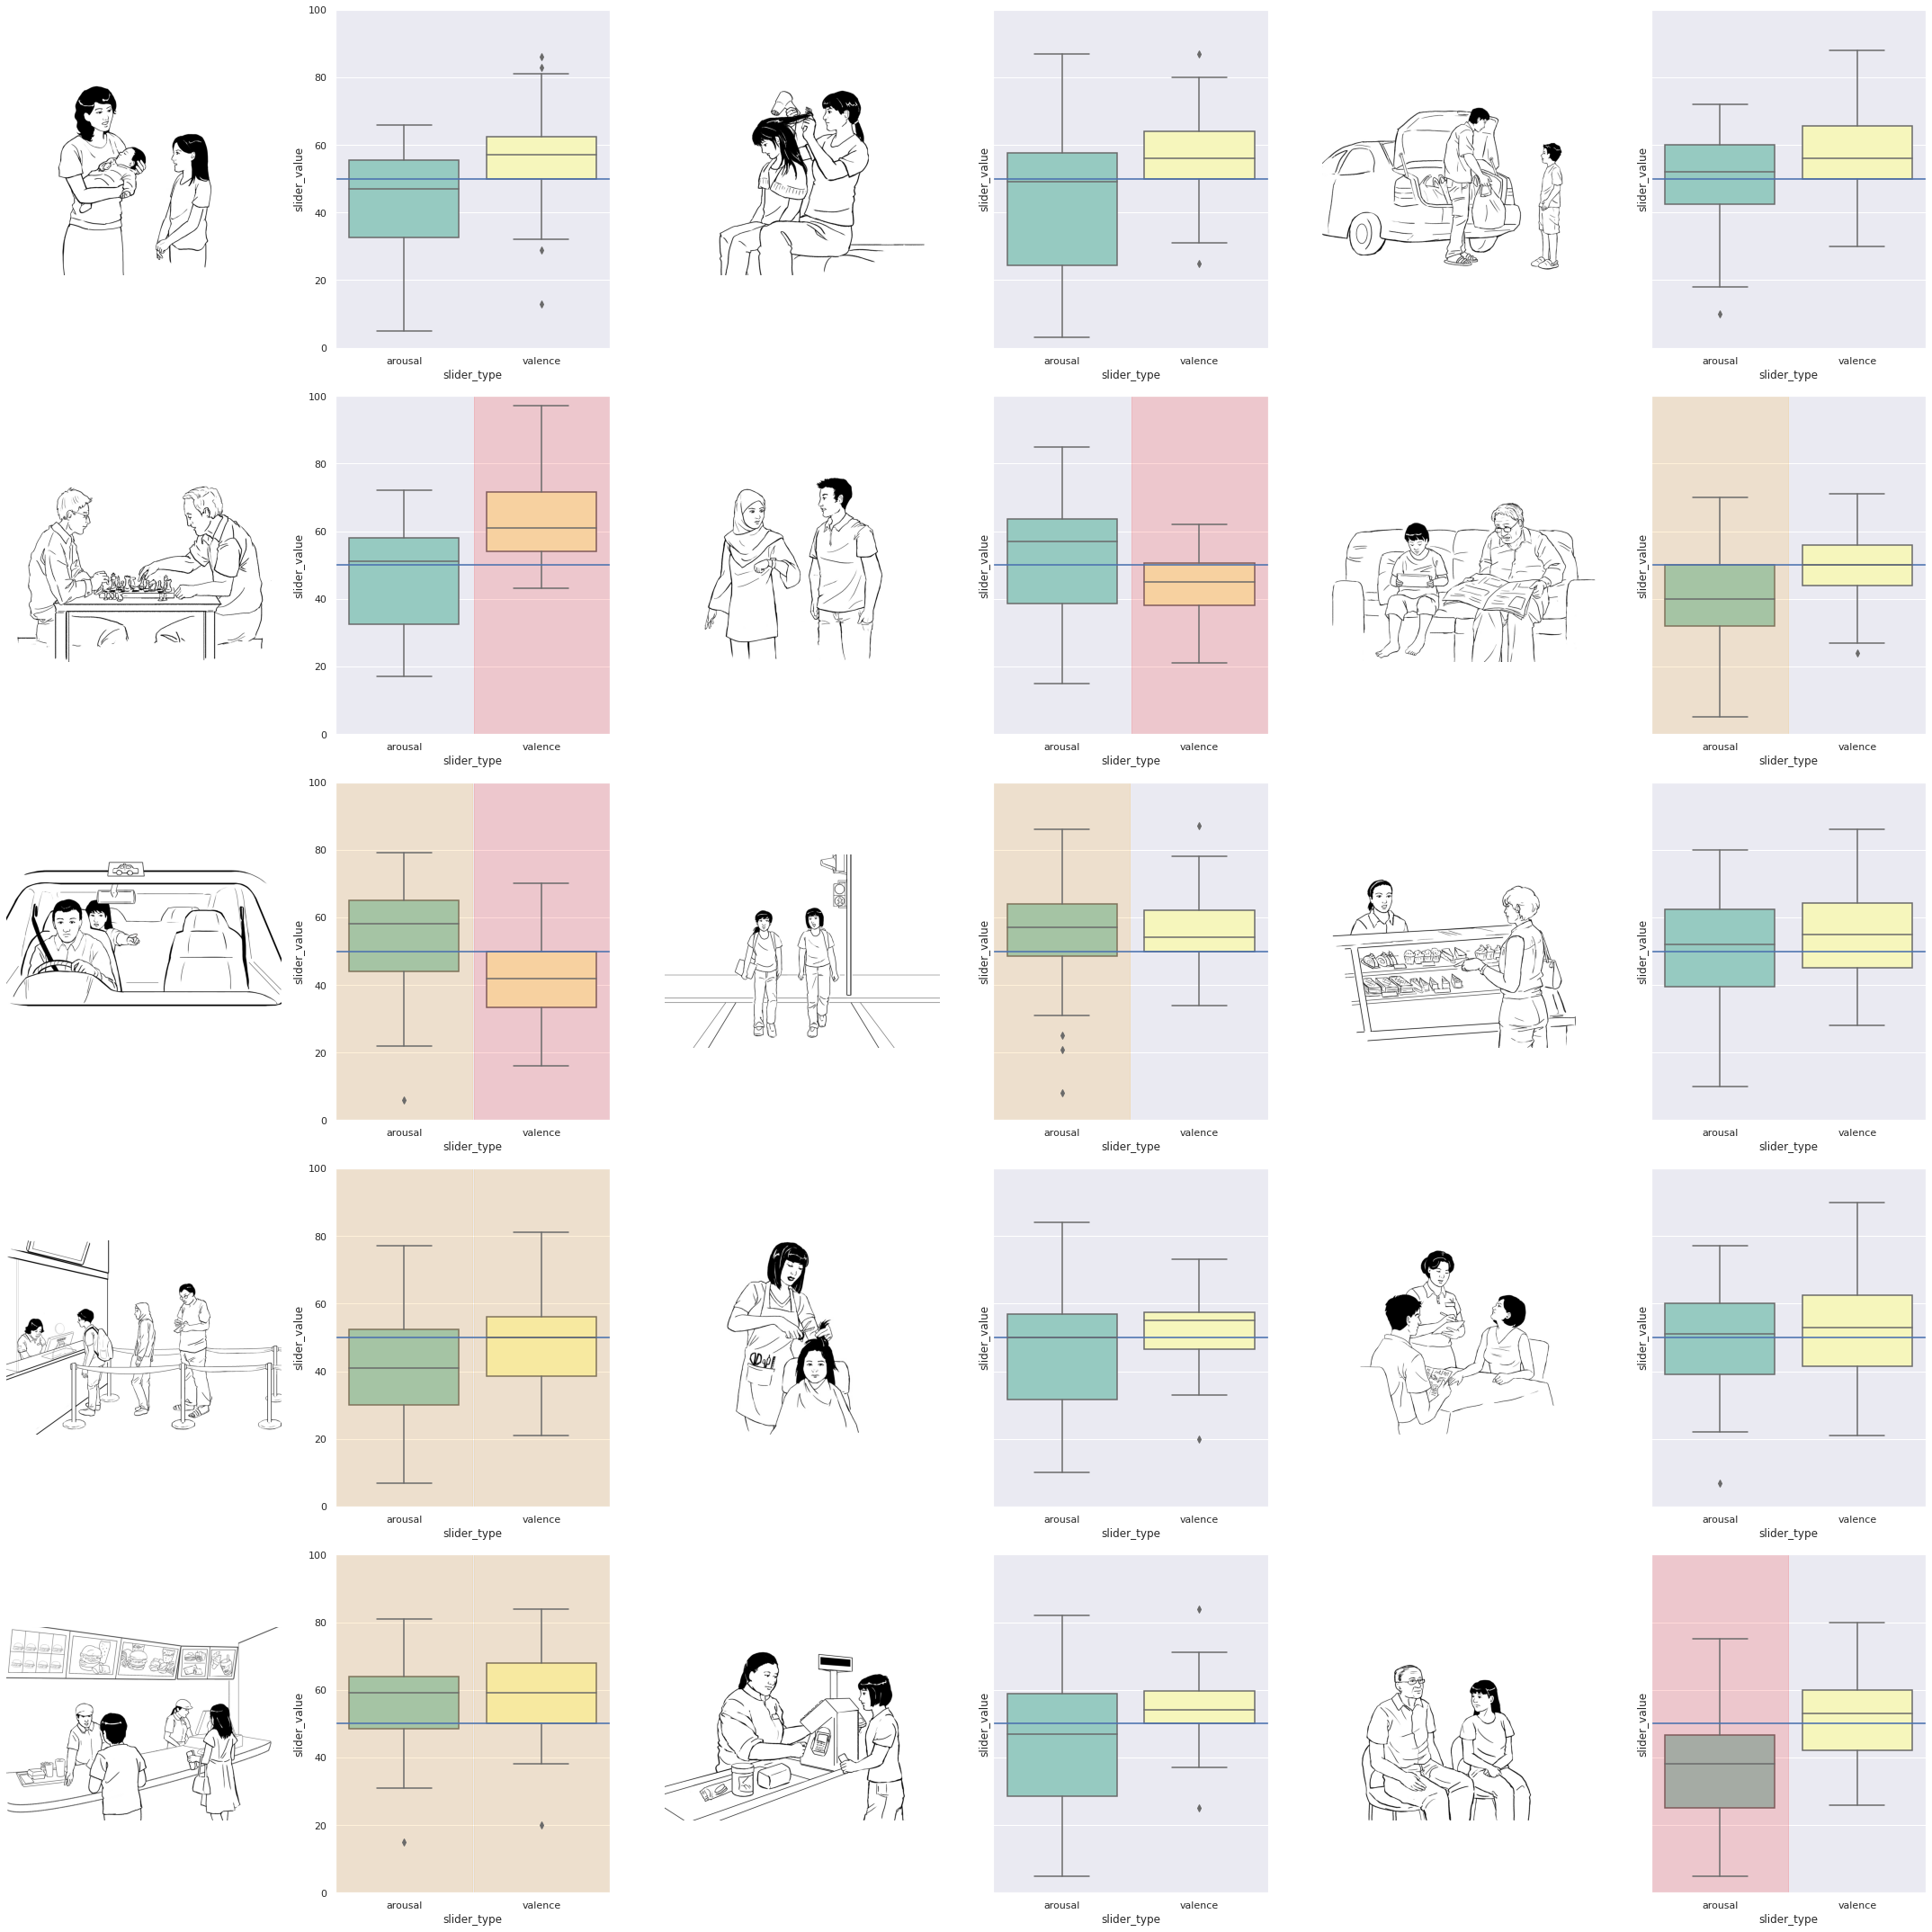

In [22]:
n_cols = 6
DB = "PiSCES"
fig, axs = plt.subplots(nrows=math.ceil(30 / n_cols), ncols=n_cols, figsize=(30, 30))

set_share_axes(axs=axs[:, 1::2], sharey=True)

for i, pic_name in enumerate(sorted(df_session[df_session.DB == DB].pic_name.unique())):
    ix2 = i * 2

    with open(
        list(speech_web_app_image_dir.joinpath(DB).glob(f"{pic_name}*"))[0], "rb"
    ) as f:
        img = plt.imread(f)

    if len(img.shape) == 2:
        img = np.repeat(img, 3).reshape(img.shape + (3,))

    axs[ix2 // n_cols, ix2 % n_cols].imshow(img)
    axs[ix2 // n_cols, ix2 % n_cols].axis("off")

    arousal_p = df[(df.pic_name == pic_name) & (df.variable == 'arousal')].p_value.values[0]
    valence_p = df[(df.pic_name == pic_name) & (df.variable == 'valence')].p_value.values[0]

    if arousal_p < 0.001:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(-.5, .493, color='red', alpha=0.15)
    elif arousal_p < 0.05:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(-.5, .493, color='orange', alpha=0.15)

    if valence_p < 0.001:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(.507, 1.5, color='red', alpha=0.15)
    elif valence_p < 0.05:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(.507, 1.5, color='orange', alpha=0.15)


    sns.boxplot(
        ax=axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols],
        data=df_session[(df_session.DB == DB) & (df_session.pic_name == pic_name)].melt(
            id_vars=set(df_session.columns).difference({"arousal", "valence"}),
            value_vars=["arousal", "valence"],
            var_name="slider_type",
            value_name="slider_value",
        ),
        x="slider_type",
        y="slider_value",
        palette="Set3",
        # bw=0.3,
        # inner="quartile",
    )

for ax in axs[:, 1::2].flat:
    ax.axhline(50, alpha=0.8, lw=2)
    ax.set_ylim(0, 100)

plt.tight_layout()

In [23]:
fig.savefig('../reports/pisces.png', dpi=250)

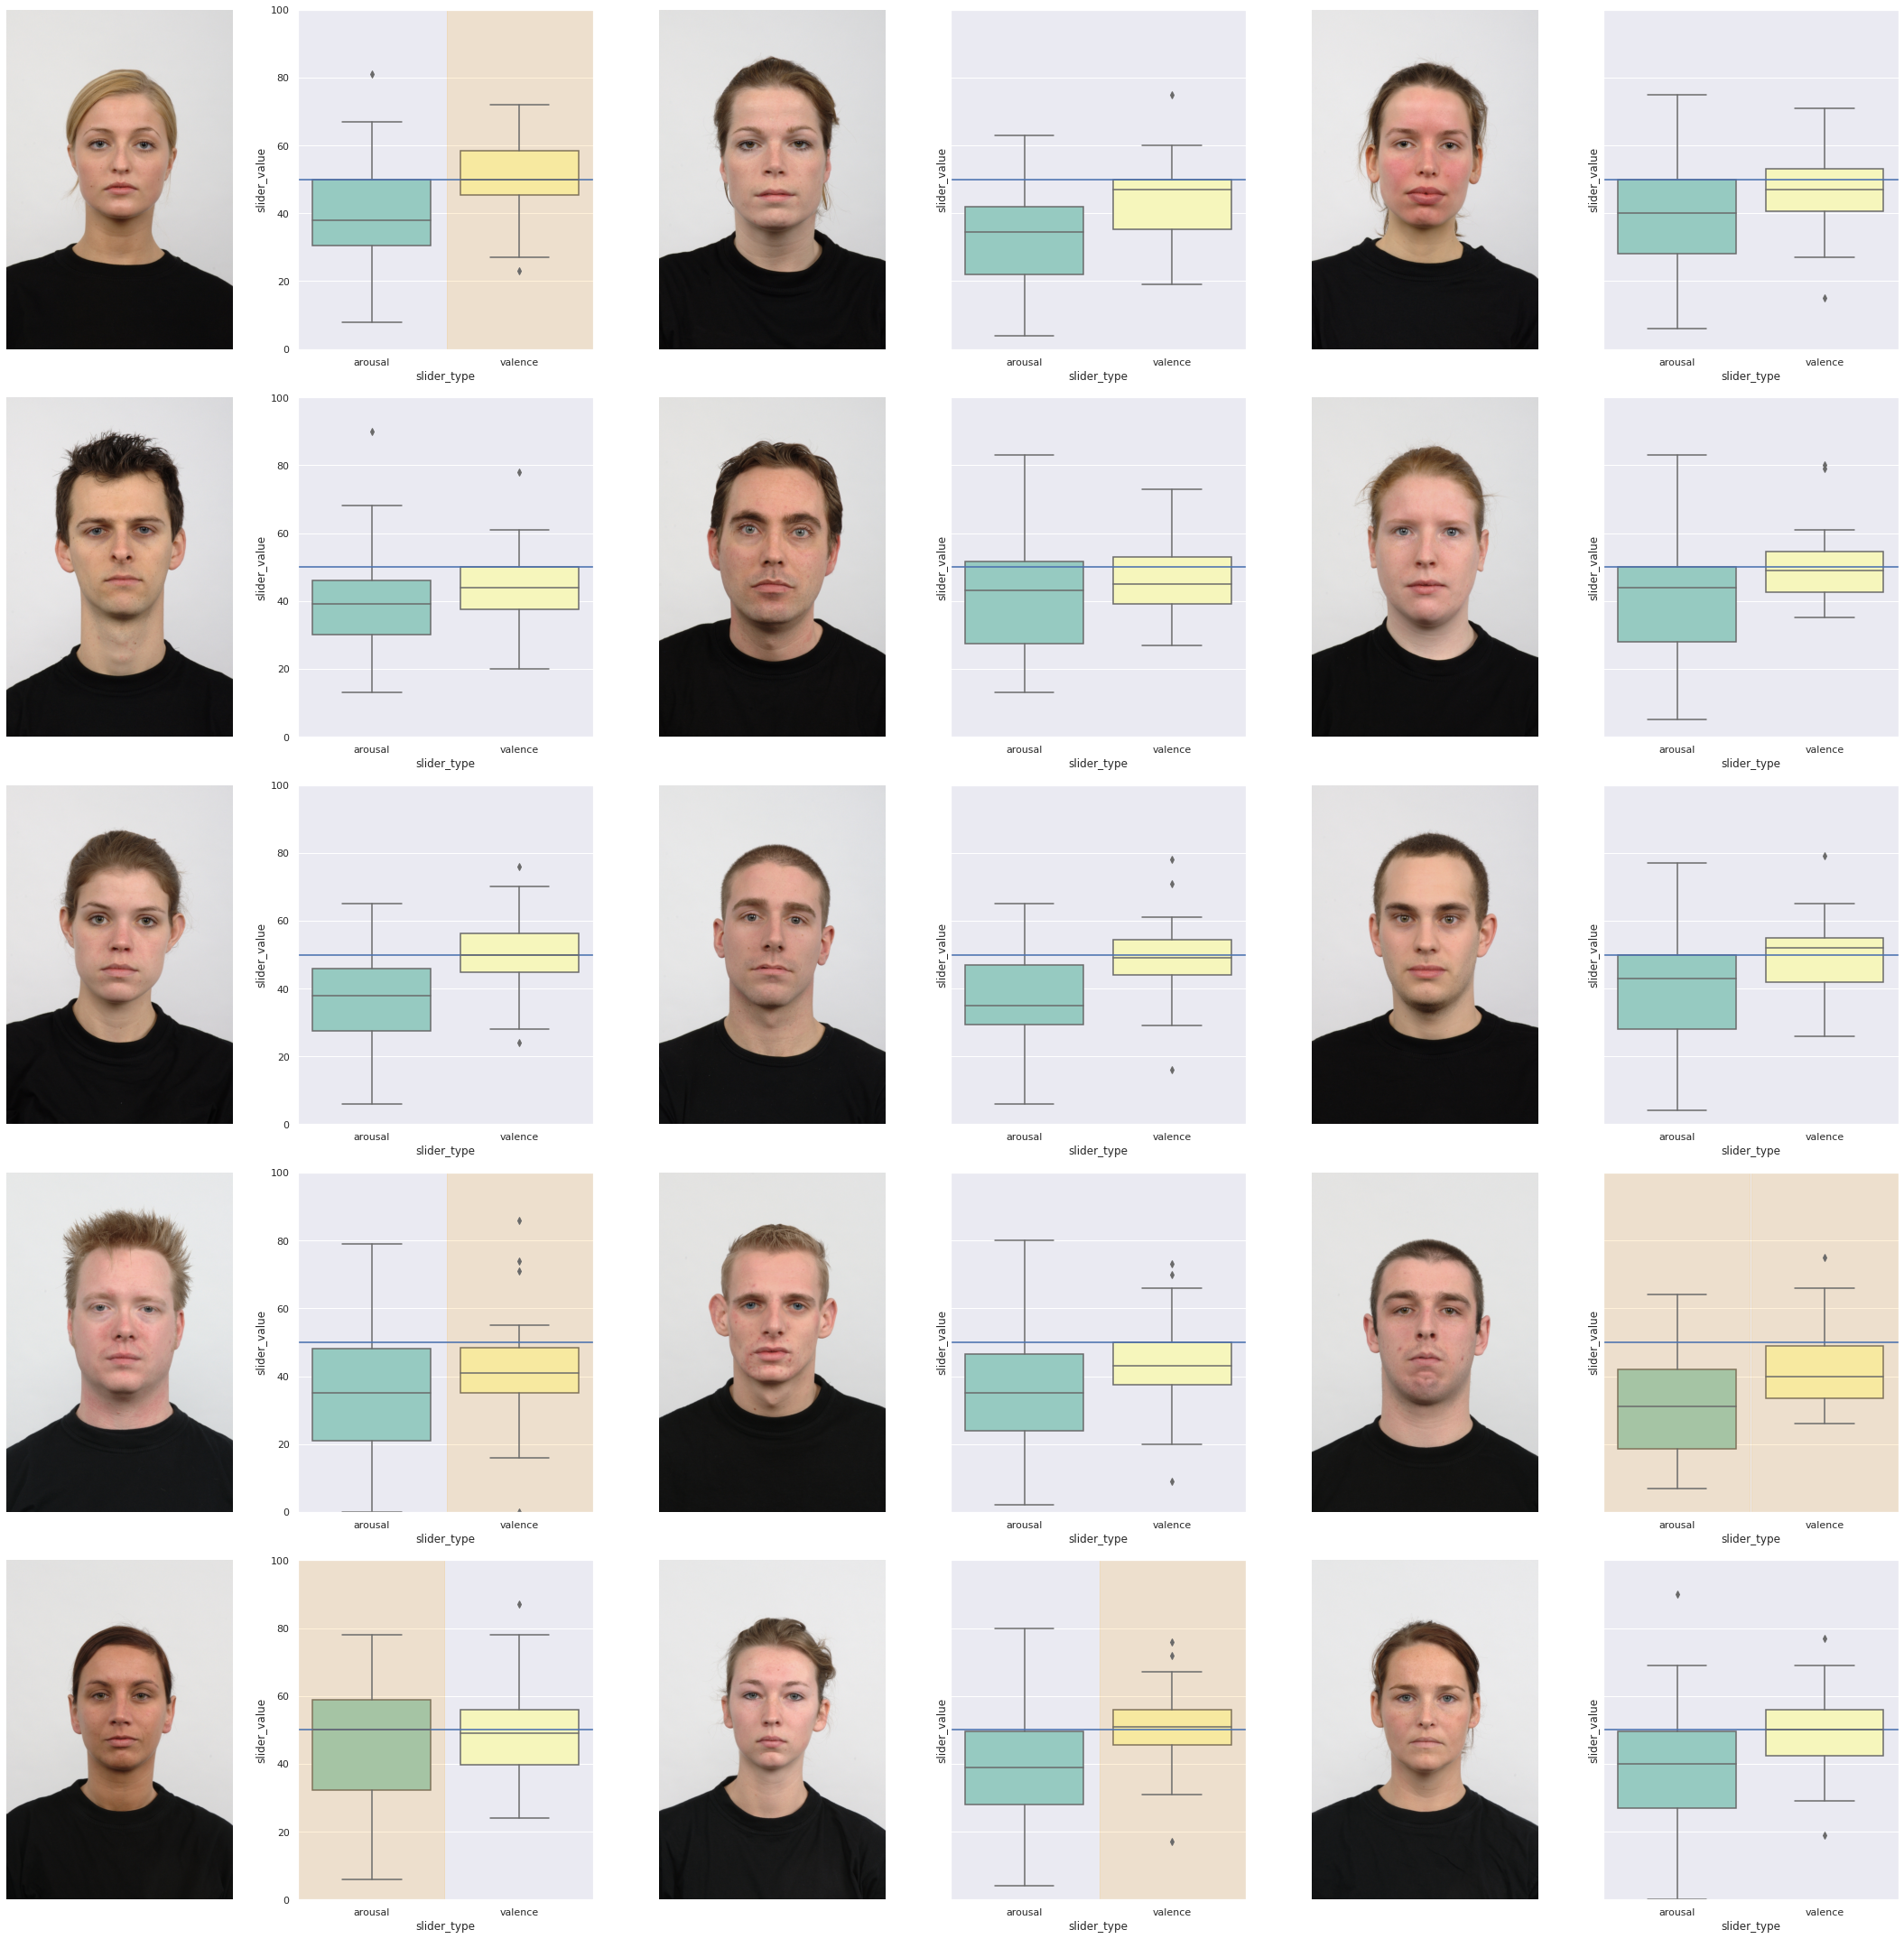

In [24]:
n_cols = 6
DB = "Radboud"
fig, axs = plt.subplots(nrows=math.ceil(30 / n_cols), ncols=n_cols, figsize=(30, 30))

set_share_axes(axs=axs[:, 1::2], sharey=True)

for i, pic_name in enumerate(sorted(df_session[df_session.DB == DB].pic_name.unique())):
    ix2 = i * 2

    with open(
        list(speech_web_app_image_dir.joinpath(DB).glob(f"{pic_name}*"))[0], "rb"
    ) as f:
        img = plt.imread(f)

    axs[ix2 // n_cols, ix2 % n_cols].imshow(img)
    axs[ix2 // n_cols, ix2 % n_cols].axis("off")

    arousal_p = df[(df.pic_name == pic_name) & (df.variable == 'arousal')].p_value.values[0]
    valence_p = df[(df.pic_name == pic_name) & (df.variable == 'valence')].p_value.values[0]

    if arousal_p < 0.001:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(-.5, .493, color='red', alpha=0.15)
    elif arousal_p < 0.05:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(-.5, .493, color='orange', alpha=0.15)

    if valence_p < 0.001:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(.507, 1.5, color='red', alpha=0.15)
    elif valence_p < 0.05:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(.507, 1.5, color='orange', alpha=0.15)

    sns.boxplot(
        ax=axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols],
        data=df_session[(df_session.DB == DB) & (df_session.pic_name == pic_name)].melt(
            id_vars=set(df_session.columns).difference({"arousal", "valence"}),
            value_vars=["arousal", "valence"],
            var_name="slider_type",
            value_name="slider_value",
        ),
        x="slider_type",
        y="slider_value",
        palette="Set3",
        # bw=0.2,
        # inner="quartile",
    )

for ax in axs[:, 1::2].flat:
    ax.set_ylim(0, 100)
    ax.axhline(50, alpha=0.8, lw=2)

plt.tight_layout()

In [25]:
fig.savefig('../reports/radboud.png', dpi=250)

## Over time

In [26]:
df_session[df_session.DB == "marloes"].session_no.value_counts()

1     29
7     29
13    28
25    28
31    28
19    27
37    27
18     2
20     2
36     2
38     2
30     2
24     2
6      1
32     1
11     1
5      1
26     1
14     1
12     1
Name: session_no, dtype: int64

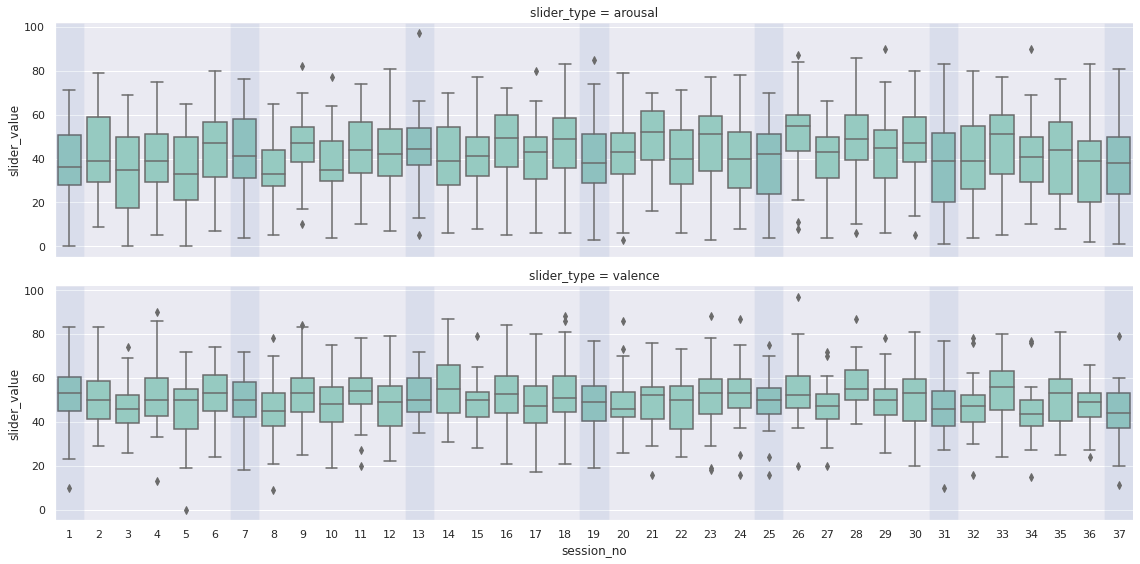

In [27]:
g = sns.catplot(
    data=df_session[(df_session.DB_no < 16) & (df_session.session_no < 38)].melt(
        id_vars=set(df_session.columns).difference({"arousal", "valence"}),
        value_vars=["arousal", "valence"],
        var_name='slider_type',
        value_name='slider_value'
    ),
    sharex=True,
    sharey=True,
    legend=True,
    kind='box', 
    x='session_no',
    y='slider_value',
    row='slider_type',
    # color='lightseagreen',
    color=(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    height=4,
    aspect=4,
)


for ax in g.axes.flat:
    for marloes_id in [1, 7, 13, 19, 25, 31, 37]:
        ax.axvspan(marloes_id - 1.5, marloes_id - 0.5, alpha=0.1)

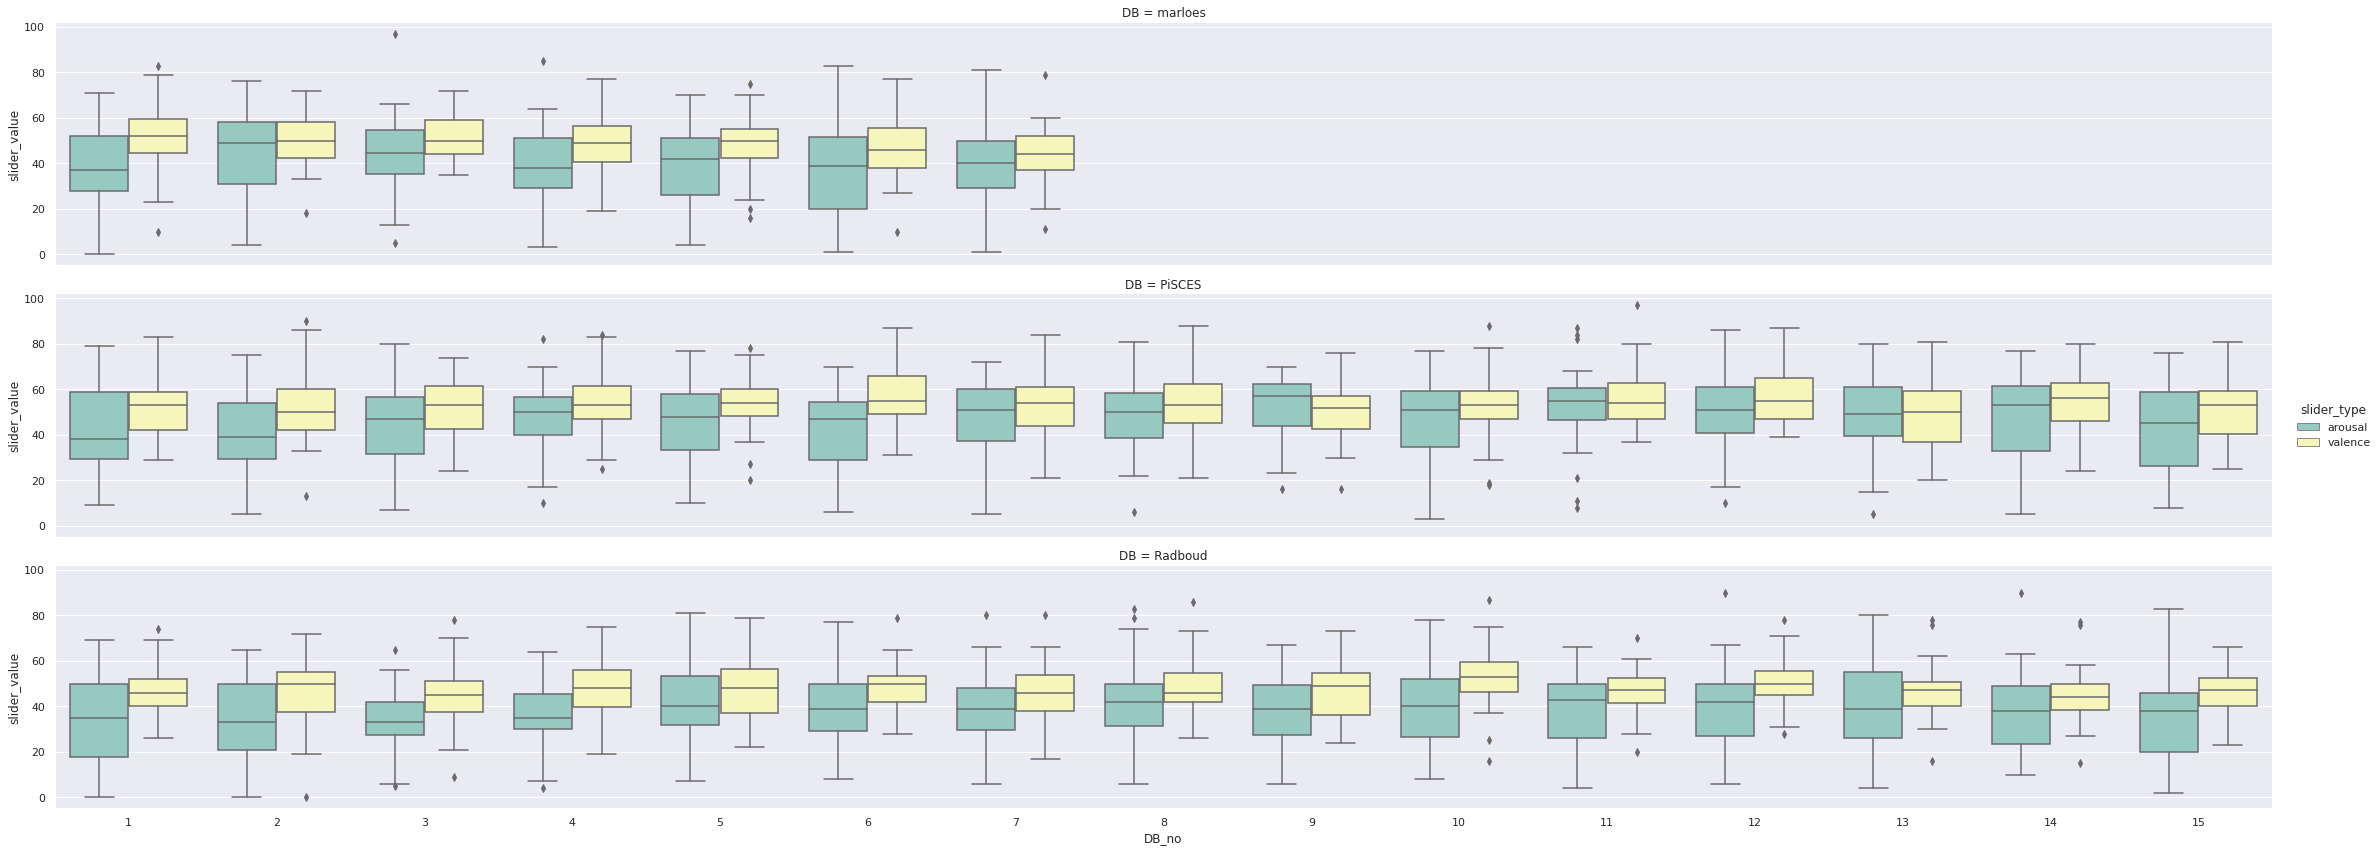

In [28]:
sns.catplot(
    data=df_session[df_session.DB_no < 16].melt(
        id_vars=set(df_session.columns).difference({"arousal", "valence"}),
        value_vars=["arousal", "valence"],
        var_name="slider_type",
        value_name="slider_value",
    ),
    sharex=True,
    sharey=True,
    legend=True,
    kind="box",
    x="DB_no",
    y='slider_value',
    hue="slider_type",
    row="DB",
    palette="Set3",
    height=4,
    aspect=8,
)

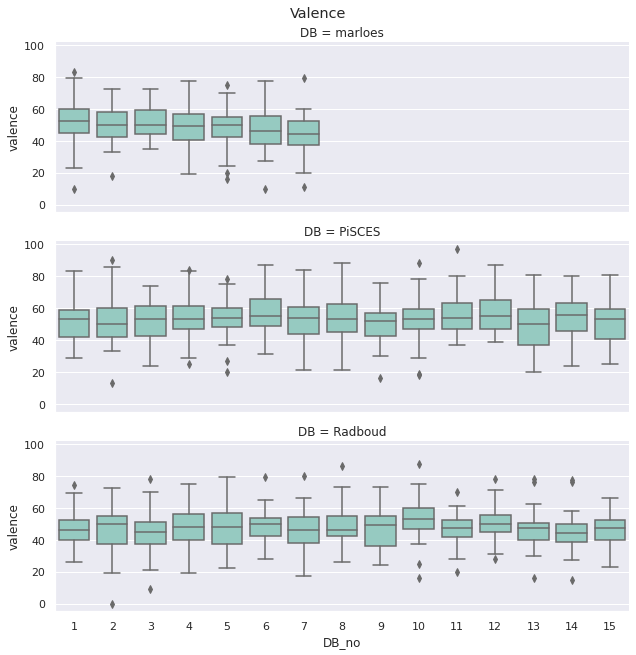

------------------------------------------------------------------------------------------------------------------------


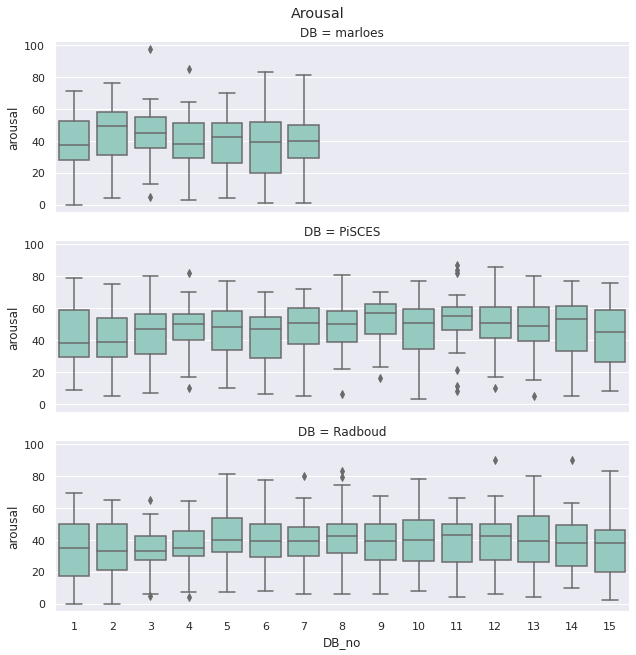

In [29]:
g = sns.catplot(
    data=df_session[df_session.DB_no < 16],
    sharex=True,
    sharey=True,
    legend=True,
    kind="box",
    x="DB_no",
    y="valence",
    row="DB",
    color=(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    height=3,
    aspect=3,
)
g.fig.suptitle("Valence", y=1.01)
plt.show()

print("-" * 120)
g = sns.catplot(
    data=df_session[df_session.DB_no < 16],
    sharex=True,
    sharey=True,
    legend=True,
    kind="box",
    x="DB_no",
    y="arousal",
    row="DB",
    # color='lightseagreen',
    color=(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    height=3,
    aspect=3,
)
g.fig.suptitle("Arousal", y=1.01)
plt.show()